In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
import pyro
import pyro.distributions as dist

from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO

# Beta-Bernoulli (coin-flip) model

In [3]:
# p ~ Beta(1, 1)
# x_i ~ Bernoulli(p)

pyro.clear_param_store()

data = torch.FloatTensor([1, 1, 1, 1, 1, 1])

def model(data):
    # p(x, theta)
    theta = pyro.sample('theta', dist.Beta(1, 1))
    with pyro.plate("data"):
        pyro.sample('x', dist.Bernoulli(theta), obs=data)
    return theta

def guide(data):
    # q(theta)
    alpha = pyro.param('alpha', torch.tensor(1.0), constraint=constraints.positive)
    beta = pyro.param('beta', torch.tensor(1.0), constraint=constraints.positive)    
    return pyro.sample('theta', dist.Beta(alpha, beta))


In [4]:
with pyro.poutine.trace() as tr:
    print(guide(data))
tr.trace.nodes['theta']

tensor(0.6947, grad_fn=<SelectBackward0>)


{'type': 'sample',
 'name': 'theta',
 'fn': Beta(),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor(0.6947, grad_fn=<SelectBackward0>),
 'infer': {},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (),
 'done': True,
 'stop': False,
 'continuation': None}

In [5]:
# tr.trace.nodes
pyro.get_param_store().keys()

dict_keys(['alpha', 'beta'])

In [6]:
pyro.param('alpha')

tensor(1., grad_fn=<AddBackward0>)

In [7]:
# E_q [ log p - log q ]

svi = SVI(model, guide, pyro.optim.Adagrad({'lr': 0.1}), loss=Trace_ELBO())

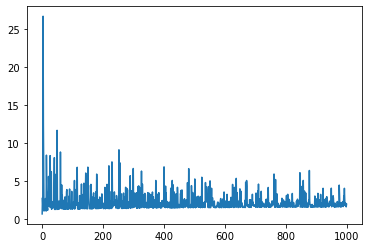

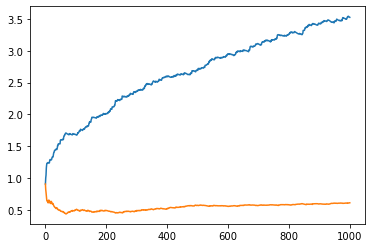

In [8]:
ELBO = []
alphas = []
betas = []

for i in range(1000):
    ELBO.append(svi.step(data))
    alphas.append(pyro.param('alpha').item())
    betas.append(pyro.param('beta').item())
    
plt.plot(ELBO)
plt.figure()
plt.plot(alphas)
plt.plot(betas);

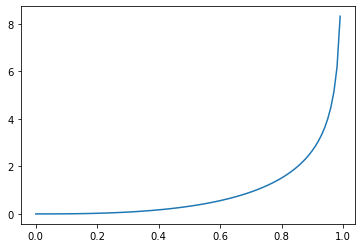

In [9]:
with torch.no_grad():
    theta_dist = dist.Beta(pyro.param('alpha'), pyro.param('beta'));
    
plt.plot(torch.linspace(0, 1, 100), theta_dist.log_prob(torch.linspace(0, 1, 100)).exp());


# Bayesian Linear model

In [10]:
from torchvision.datasets import MNIST

train_data = MNIST('data/', train=True)
X = train_data.data / 255.0
y = train_data.targets

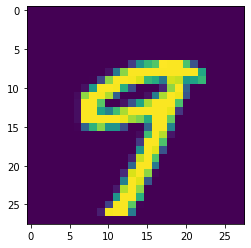

In [11]:
plt.imshow(X[2643]);

In [12]:
pyro.clear_param_store()

In [13]:
def model(X, y=None):
    
    W = pyro.sample('W', dist.Normal(0, 1).expand((10, 784)).to_event(2))
    b = pyro.sample('b', dist.Normal(0, 1).expand((10,)).to_event(1))

    with pyro.plate('data', len(X), subsample_size=100) as ind:
        y_hat = X[ind].reshape(-1, 784) @ W.T + b.unsqueeze(0)
        if y is not None:
            y = y[ind]
        return pyro.sample('y', dist.Categorical(logits=y_hat), obs=y)
    
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

In [14]:
with pyro.poutine.trace() as tr:
    print(guide(X, y))
# tr.trace.nodes['theta']

{'W': tensor([[ 0.0444,  0.1141,  0.2701,  ...,  0.1245, -0.2761, -0.3035],
        [-0.4579,  0.2910, -0.0201,  ..., -0.4587, -0.0579,  0.2744],
        [ 0.0399,  0.0368, -0.7130,  ...,  0.2567,  0.0749, -0.0705],
        ...,
        [ 0.6124,  0.3582, -0.4029,  ...,  0.4609, -0.0751, -0.2068],
        [-0.3437, -0.0341, -0.6237,  ...,  0.0425,  0.4450,  0.2709],
        [-0.1284, -0.2135, -0.3449,  ..., -0.0530, -0.0141,  0.4539]],
       grad_fn=<ExpandBackward0>), 'b': tensor([ 0.3054, -0.1621,  0.3131, -0.0134, -0.3049, -0.0659,  0.3374, -0.0327,
        -0.7530,  0.0489], grad_fn=<ExpandBackward0>)}


In [15]:
svi = SVI(model, guide, pyro.optim.Adam({'lr': 0.01}), loss=Trace_ELBO())

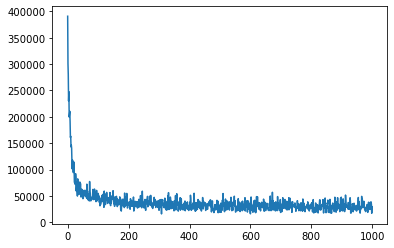

In [16]:
ELBO = []
for _ in range(1000):
    ELBO.append(svi.step(X, y))
    
plt.plot(ELBO)

In [17]:
with torch.no_grad():
    sample = guide(X)
    y_hat = X.reshape(-1, 784) @ sample['W'].T + sample['b'][None,:]
    
(y_hat.argmax(-1) == y).float().mean()

tensor(0.9075)

# Bayesian neural network

Deterministic features; Bayesian last layer

In [18]:
pyro.clear_param_store()

features = torch.nn.Sequential(nn.Flatten(),
                               nn.Linear(784, 200), nn.ReLU(),
                               nn.Linear(200, 50), nn.ReLU())

pyro.nn.module.to_pyro_module_(features)

features

PyroSequential(
  (0): PyroFlatten(start_dim=1, end_dim=-1)
  (1): PyroLinear(in_features=784, out_features=200, bias=True)
  (2): PyroReLU()
  (3): PyroLinear(in_features=200, out_features=50, bias=True)
  (4): PyroReLU()
)

In [19]:

def model(X, y=None):
    
    W = pyro.sample('W', dist.Normal(0, 1).expand((10, 50)).to_event(2))
    b = pyro.sample('b', dist.Normal(0, 1).expand((10,)).to_event(1))

    with pyro.plate('data', len(X), subsample_size=100) as ind:
        y_hat = features(X[ind]) @ W.T + b.unsqueeze(0)
        if y is not None:
            y = y[ind]
        return pyro.sample('y', dist.Categorical(logits=y_hat), obs=y)
    
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

In [20]:
model(X, y)
guide(X, y)

pyro.get_param_store().keys()

dict_keys(['1.weight', '1.bias', '3.weight', '3.bias', 'AutoDiagonalNormal.loc', 'AutoDiagonalNormal.scale'])

In [21]:
svi = SVI(model, guide, pyro.optim.Adam({'lr': 0.01}), loss=Trace_ELBO())

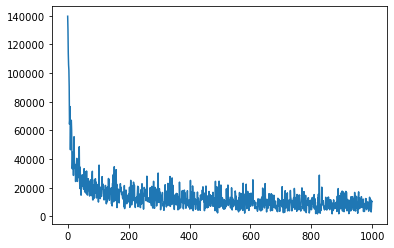

In [22]:
ELBO = []
for _ in range(1000):
    ELBO.append(svi.step(X, y))
    
plt.plot(ELBO)

In [23]:
def make_prediction(X):
    samples = guide(X)
    H = features(X)
    return H @ samples['W'].T + samples['b'][None,:]

with torch.no_grad():
    y_hat = make_prediction(X)
    
(y_hat.argmax(-1) == y).float().mean()

tensor(0.9667)

# Tricky dataset: 1000 examples, no eights

In [24]:
ind_trick = torch.arange(len(y))[y != 8][:1000]

X_data = X[ind_trick]
y_data = y[ind_trick]

In [25]:
pyro.clear_param_store()

features = torch.nn.Sequential(nn.Flatten(),
                               nn.Linear(784, 200), nn.ReLU(),
                               nn.Linear(200, 50), nn.ReLU())

pyro.nn.module.to_pyro_module_(features)


def model(X, y=None):
    
    W = pyro.sample('W', dist.Normal(0, 1).expand((10, 50)).to_event(2))
    b = pyro.sample('b', dist.Normal(0, 1).expand((10,)).to_event(1))

    with pyro.plate('data', len(X), subsample_size=100) as ind:
        y_hat = features(X[ind]) @ W.T + b.unsqueeze(0)
        if y is not None:
            y = y[ind]
        return pyro.sample('y', dist.Categorical(logits=y_hat), obs=y)
    

guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

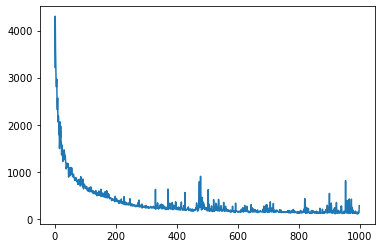

In [26]:
svi = SVI(model, guide, pyro.optim.Adam({'lr': 0.01}), loss=Trace_ELBO())

ELBO = []
for _ in range(1000):
    ELBO.append(svi.step(X_data, y_data))
    
plt.plot(ELBO)

In [27]:
X_test = X[-50000:]
y_test = y[-50000:]

In [28]:
with torch.no_grad():
    y_hat = make_prediction(X_test)

(y_hat.argmax(-1) == y_test).float().mean()

tensor(0.7981)

In [29]:
for k in range(10):
    print(k, (y_hat.argmax(-1) == y_test)[y_test==k].float().mean())

0 tensor(0.9423)
1 tensor(0.9687)
2 tensor(0.9068)
3 tensor(0.7949)
4 tensor(0.9239)
5 tensor(0.8311)
6 tensor(0.8917)
7 tensor(0.9501)
8 tensor(0.)
9 tensor(0.7403)


In [30]:
# Look at BALD objective (MI[y, latents | x])

y_hat_samples = [] 
with torch.no_grad():
    for _ in range(20):
        y_hat = make_prediction(X_test)
        y_hat_samples.append(y_hat)
y_hat_samples = torch.stack(y_hat_samples)

In [31]:
H_avg = dist.Categorical(probs=torch.softmax(y_hat_samples, -1).mean(0)).entropy()

In [32]:
H_each = torch.stack([dist.Categorical(logits=y_hat).entropy() for y_hat in y_hat_samples]).mean(0)

assert H_each.shape == H_avg.shape

In [33]:
MI = H_avg - H_each

In [34]:
idx = MI.argsort()

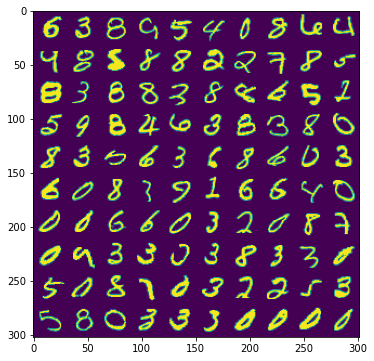

In [35]:
from torchvision.utils import make_grid

plt.figure(figsize=(6,6));
plt.imshow(make_grid(X_test[idx[-100:]].unsqueeze(1), nrow=10)[0]);

In [36]:
def check_accuracy(which):
    return ((y_hat_samples[:,which].mean(0).argmax(-1) == y_test[which]).float().mean())

In [37]:
print("accuracy of points with high MI: %0.2f" % check_accuracy(idx[-100:]).item())

accuracy of points with high MI: 0.24


accuracy of points with low MI: 0.98


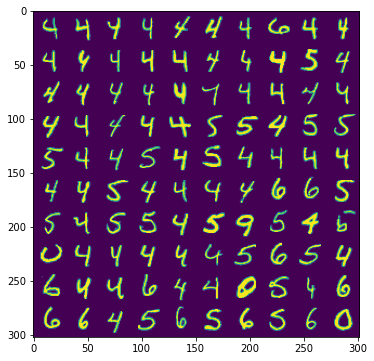

In [38]:
print("accuracy of points with low MI: %0.2f" % check_accuracy(idx[:100]).item())
plt.figure(figsize=(6,6));
plt.imshow(make_grid(X_test[idx[:100]].unsqueeze(1), nrow=10)[0]);

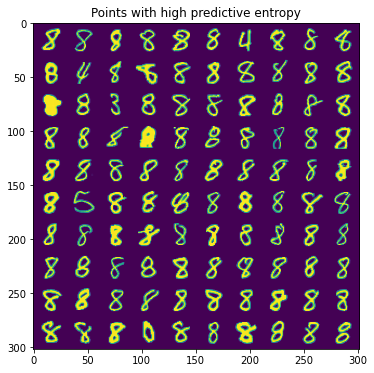

In [40]:
# Entropy instead of MI

idx = H_avg.argsort()

plt.figure(figsize=(6,6));
plt.imshow(make_grid(X_test[idx[-100:]].unsqueeze(1), nrow=10)[0]);
plt.title("Points with high predictive entropy");